In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import PIL
from io import BytesIO
from IPython.display import clear_output, Image as NoteImage, display
from sklearn.model_selection import train_test_split

In [21]:
%matplotlib notebook
def imshow(im,fmt='jpeg'):
    #a = np.uint8(np.clip(im, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(im).save(f, fmt)
    display(NoteImage(data=f.getvalue()))
def imread(filename):
    img = cv.imread(filename)

    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

In [4]:
data=pd.read_csv("Fall 2019 Plumes detected by AVIRIS-NG and GAO provided by NASA-JPL and U.Arizona.csv")
data

,source_id,plume_lat,plume_lon,plume_candidate_id,date_of_detection,time_of_detection,source_type,source_type_label,ipcc,qplume,sigma_qplume,active_flare,inactive_flare,Operator_Alias,imageurl
0,P00156,32.283447,-103.741815,ang20190922t192642-A,9/23/2019,7:26:42 PM,compressor,Midstream,1B2 Oil & Natural Gas,296.676732,98.755811,False,False,DCP MIDSTREAM PARTNERS,https://edf-permian-data.s3.amazonaws.com/imag...
1,P00119,32.244361,-103.711379,ang20190922t192642-B,9/23/2019,7:26:42 PM,tank,Production,1B2 Oil & Natural Gas,640.968143,190.138173,False,False,DEVON ENERGY PRODUCTION CO,https://edf-permian-data.s3.amazonaws.com/imag...
2,P00475,32.166625,-103.685468,ang20190922t194340-A,9/23/2019,7:43:40 PM,tank,Production,1B2 Oil & Natural Gas,1091.242729,310.028504,False,False,DEVON ENERGY PRODUCTION CO,https://edf-permian-data.s3.amazonaws.com/imag...
3,P00002,32.200072,-103.673301,ang20190922t192642-4,9/23/2019,7:26:42 PM,tank,Production,1B2 Oil & Natural Gas,420.725207,147.155782,False,False,ENLINK,https://edf-permian-data.s3.amazonaws.com/imag...
4,P00003,32.116008,-103.626345,ang20190922t192642-5,9/23/2019,7:26:42 PM,tank,Production,1B2 Oil & Natural Gas,1051.909600,339.267587,False,False,EOG RESOURCES INC,https://edf-permian-data.s3.amazonaws.com/imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3062,P01769,31.478768,-102.958800,GAO20191103t163539p0000-C,11/4/2019,4:35:39 PM,compressor,Midstream,1B2 Oil & Natural Gas,159.291858,64.873698,False,False,UNKNOWN,https://edf-permian-data.s3.amazonaws.com/imag...
3063,P01784,32.793745,-104.123650,GAO20191103t181042p0000-A,11/4/2019,6:10:42 PM,pipeline,Midstream,1B2 Oil & Natural Gas,250.722494,51.888206,False,False,UNKNOWN,https://edf-permian-data.s3.amazonaws.com/imag...
3064,P01784,32.793674,-104.123290,GAO20191103t182306p0000-B,11/4/2019,6:23:06 PM,pipeline,Midstream,1B2 Oil & Natural Gas,298.184474,68.096895,False,False,UNKNOWN,https://edf-permian-data.s3.amazonaws.com/imag...
3065,P01786,32.795682,-104.163570,GAO20191103t182306p0000-C,11/4/2019,6:23:06 PM,pipeline,Midstream,1B2 Oil & Natural Gas,200.567906,36.274204,False,False,UNKNOWN,https://edf-permian-data.s3.amazonaws.com/imag...


In [5]:
def flare_extractor(img):

    x,y,c=img.shape
    real_img=np.zeros((x,y,c))
    red=img[:,:,0]
    green=img[:,:,1]
    blue=img[:,:,2]
    only_blue_carbon=np.uint8(blue>150)*np.uint8(green<120)*np.uint8(red<120)
    only_blue_carbon_sum=np.sum(only_blue_carbon)

    only_green_carbon=np.uint8(blue<120)*np.uint8(green>150)*np.uint8(red<120)

    only_green_carbon_sum=np.sum(only_green_carbon)
    only_red_carbon=np.uint8(blue<120)*np.uint8(green<120)*np.uint8(red>180)
    only_red_carbon_sum=np.sum(only_red_carbon)
    only_yellow_carbon=np.uint8(blue<120)*np.uint8(green>180)*np.uint8(red>180)
    only_yellow_carbon_sum=np.sum(only_yellow_carbon)

    real_img[:,:,0]=np.logical_xor(only_red_carbon,only_yellow_carbon)*255

    real_img[:,:,1]=np.logical_xor(only_green_carbon,only_yellow_carbon)*255
    real_img[:,:,2]=only_blue_carbon*255
    
    out=np.uint8(real_img)

    
    return out,only_red_carbon_sum, only_green_carbon_sum, only_blue_carbon_sum,only_yellow_carbon_sum

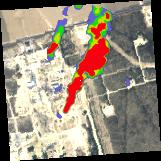

In [6]:
image=imread("images/processing-87.png")
imshow(image)

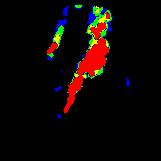

In [7]:
extracted_image,r,g,b,y=flare_extractor(image)
imshow(extracted_image)

In [8]:
df=pd.DataFrame(data,columns=["source_type","qplume"])

In [9]:
data["red"]=1
data["green"]=1
data["blue"]=1
data["yellow"]=1
data["source_type"]=data["source_type"].astype(str)

In [10]:
for i in range(len(data)):
    try:
        img=imread("images/"+data["source_type"][i]+"-"+str(i)+".png")
        

        img,r,g,b,y=flare_extractor(img)
        

        data["red"][i]=r
        data["green"][i]=g
        data["blue"][i]=b
        data["yellow"][i]=y

    except:
        print("error at "+str(i))
        pass
   

/tmp/ipykernel_6846/312141479.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["red"][i]=r
/tmp/ipykernel_6846/312141479.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["green"][i]=g
/tmp/ipykernel_6846/312141479.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["blue"][i]=b
/tmp/ipykernel_6846/312141479.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

error at 1080


In [64]:
df=data[["source_type","qplume","red","green","blue","yellow"]]
dummy=pd.get_dummies(df,columns=["source_type"],drop_first=True)
dummy.to_csv("dummys_2.0.csv",index=False)

# Testing on obtained data


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import PIL
from io import BytesIO
from IPython.display import clear_output, Image as NoteImage, display
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import sklearn.metrics as metrics

# from pycaret.regression import setup, compare_models,evaluate_model ,  predict_model,  save_model, load_model

In [23]:
data=pd.read_csv("dummys_2.0.csv")

In [13]:
data.head()

,qplume,red,green,blue,yellow,source_type_nan,source_type_pipeline,source_type_processing,source_type_tank,source_type_well
0,296.676732,0,9,226,1,0,0,0,0,0
1,640.968143,7,13,51,1,0,0,0,1,0
2,1091.242729,45,72,39,17,0,0,0,1,0
3,420.725207,0,30,74,11,0,0,0,1,0
4,1051.909600,93,44,129,1,0,0,0,1,0


In [24]:
df=data[data["source_type_nan"]!=1].drop(labels="source_type_nan",axis=1)[["qplume","red","green","blue","yellow"]]
df.head()

,qplume,red,green,blue,yellow
0,296.676732,0,9,226,1
1,640.968143,7,13,51,1
2,1091.242729,45,72,39,17
3,420.725207,0,30,74,11
4,1051.909600,93,44,129,1


<AxesSubplot: >

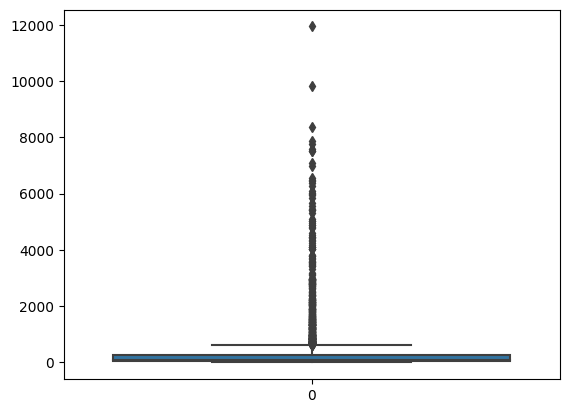

In [26]:
sns.boxplot(data['blue'])

In [27]:

# IQR
Q1_red = np.percentile(data['red'], 25,
                   interpolation = 'midpoint')
 
Q3_red = np.percentile(data['red'], 75,
                   interpolation = 'midpoint')
IQR_red = Q3_red - Q1_red

Q1_green = np.percentile(data['green'], 25, interpolation = 'midpoint')
Q3_green = np.percentile(data['green'], 75, interpolation = 'midpoint')
IQR_green = Q3_green - Q1_green

Q1_blue = np.percentile(data['blue'], 25, interpolation = 'midpoint')
Q3_blue = np.percentile(data['blue'], 75, interpolation = 'midpoint')
IQR_blue = Q3_blue - Q1_blue

Q1_yellow = np.percentile(data['yellow'], 25, interpolation = 'midpoint')
Q3_yellow = np.percentile(data['yellow'], 75, interpolation = 'midpoint')
IQR_yellow = Q3_yellow - Q1_yellow


Q1_qplume = np.percentile(data['qplume'], 25, interpolation = 'midpoint')
Q3_qplume = np.percentile(data['qplume'], 75, interpolation = 'midpoint')
IQR_qplume = Q3_qplume - Q1_qplume


/tmp/ipykernel_6846/600512016.py:2: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1_red = np.percentile(data['red'], 25,
/tmp/ipykernel_6846/600512016.py:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3_red = np.percentile(data['red'], 75,
/tmp/ipykernel_6846/600512016.py:9: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1_green = np.percentile(data['green'], 25, 

In [28]:
non_outlier_data=data[(data["red"] < (Q3_red + 1.5 * IQR_red)) & (data["red"] > (Q1_red - 1.5 * IQR_red))& (data["blue"] < (Q3_blue + 1.5 * IQR_blue)) & (data["blue"] > (Q1_blue - 1.5 * IQR_blue))& (data["green"] < (Q3_green + 1.5 * IQR_green)) & (data["green"] > (Q1_green - 1.5 * IQR_green))& (data["yellow"] < (Q3_yellow + 1.5 * IQR_yellow)) & (data["yellow"] > (Q1_yellow - 1.5 * IQR_yellow))& (data["qplume"] < (Q3_qplume + 1.5 * IQR_qplume)) & (data["qplume"] > (Q1_qplume - 1.5 * IQR_qplume))]

In [119]:
non_outlier_data.to_csv("non_outlier_data.csv",index=False)

In [29]:
non_outlier_data=pd.read_csv("non_outlier_data.csv")

In [30]:
non_outlier_data.describe()

,qplume,red,green,blue,yellow,source_type_nan,source_type_pipeline,source_type_processing,source_type_tank,source_type_well
count,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000
mean,353.139282,6.438877,31.786177,105.647084,4.541685,0.009503,0.189201,0.025486,0.365443,0.218575
std,253.037296,12.792306,35.073753,111.810265,7.568036,0.097041,0.391753,0.157630,0.481658,0.413368
min,15.029525,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169.580662,0.000000,7.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,282.578424,0.000000,21.000000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,463.903268,8.000000,44.000000,134.000000,7.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1371.909650,67.000000,193.000000,604.000000,39.000000,1.000000,1.000000,1.000000,1.000000,1.000000


/home/panda/anaconda3/envs/carbon_detector/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


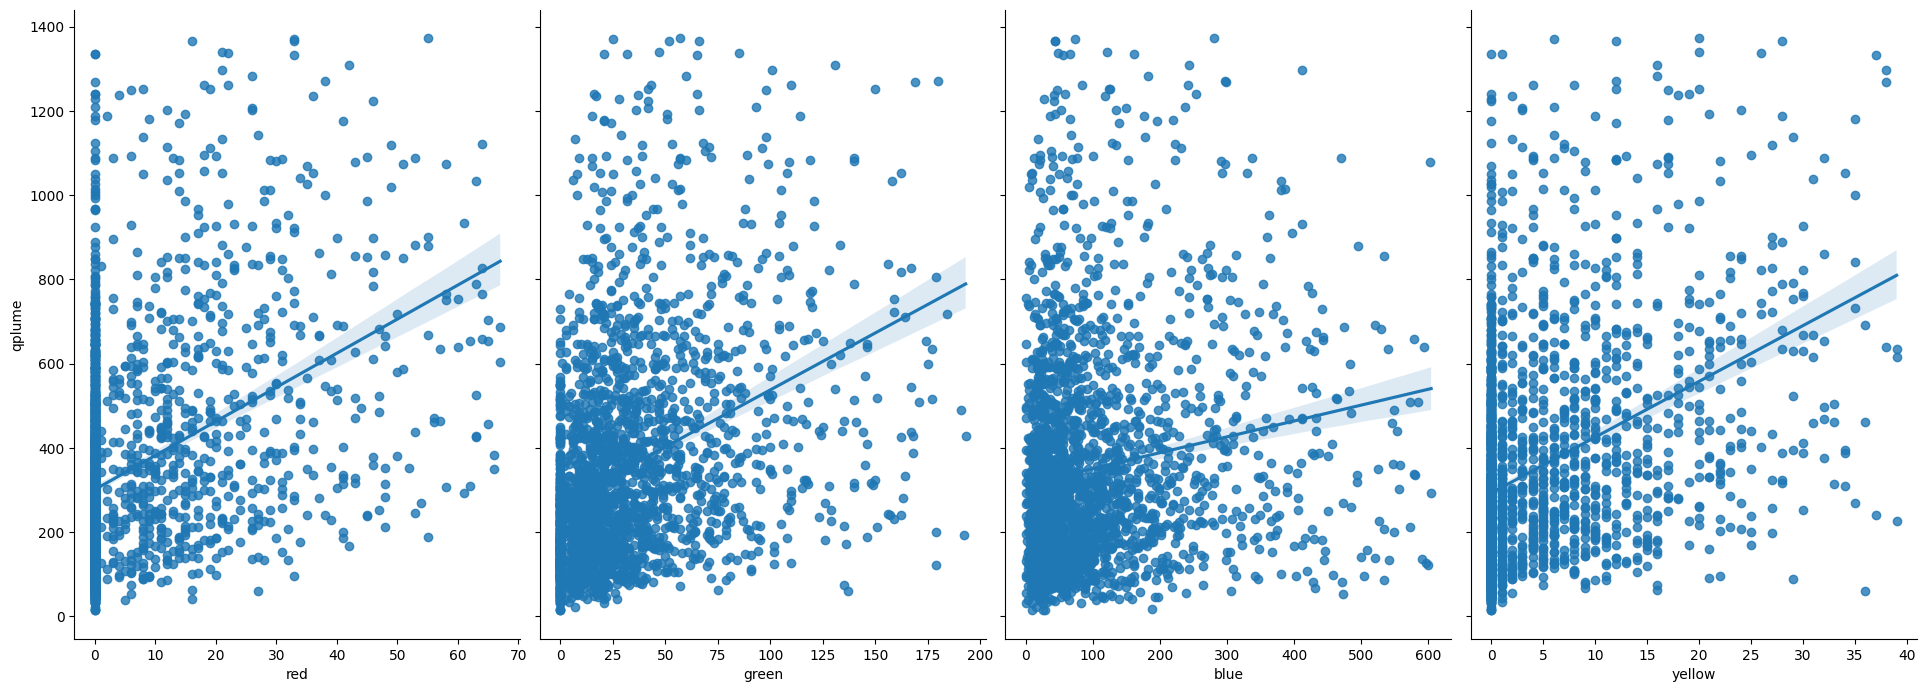

In [31]:
%matplotlib inline
import seaborn as sns
sns.pairplot(non_outlier_data, x_vars=['red', 'green', 'blue', 'yellow'], y_vars='qplume', size=7, aspect=0.7, kind='reg')

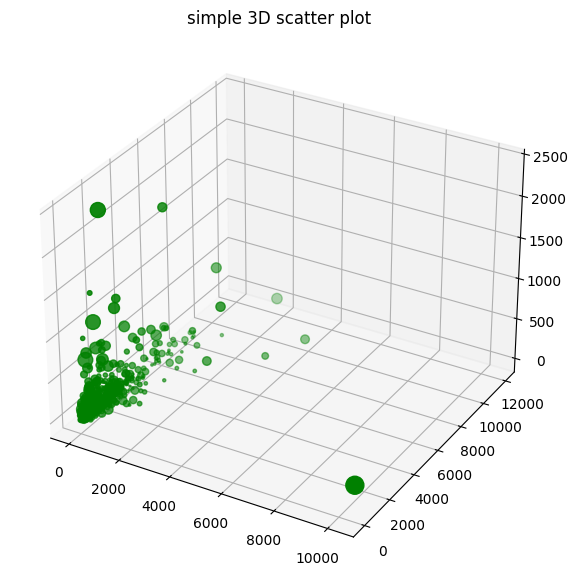

In [34]:
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
# Creating dataset
z = data["red"]
x = data["green"]
y = data["blue"]
s= data["qplume"]/100

 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z,s=s, color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

In [39]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
X=non_outlier_data[["red","green","blue","yellow"]]
y=non_outlier_data["qplume"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
LR = GradientBoostingRegressor()
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }
grid_LR = GridSearchCV(estimator=LR, param_grid = parameters, cv = 2, n_jobs=-1)
grid_LR.fit(X_train, y_train)
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_LR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_LR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_LR.best_params_)


In [127]:
model=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1)
model.fit(X_train,y_train)
# output=model.score(X_test,y_test)
# output
y_pred_train=model.predict(X_train)
output_train=np.sqrt(mean_squared_error(y_train,y_pred_train))
y_pred=model.predict(X_test)
output=np.sqrt(mean_squared_error(y_test,y_pred))

output_train,output


(220.8934608072824, 213.35018363664278)

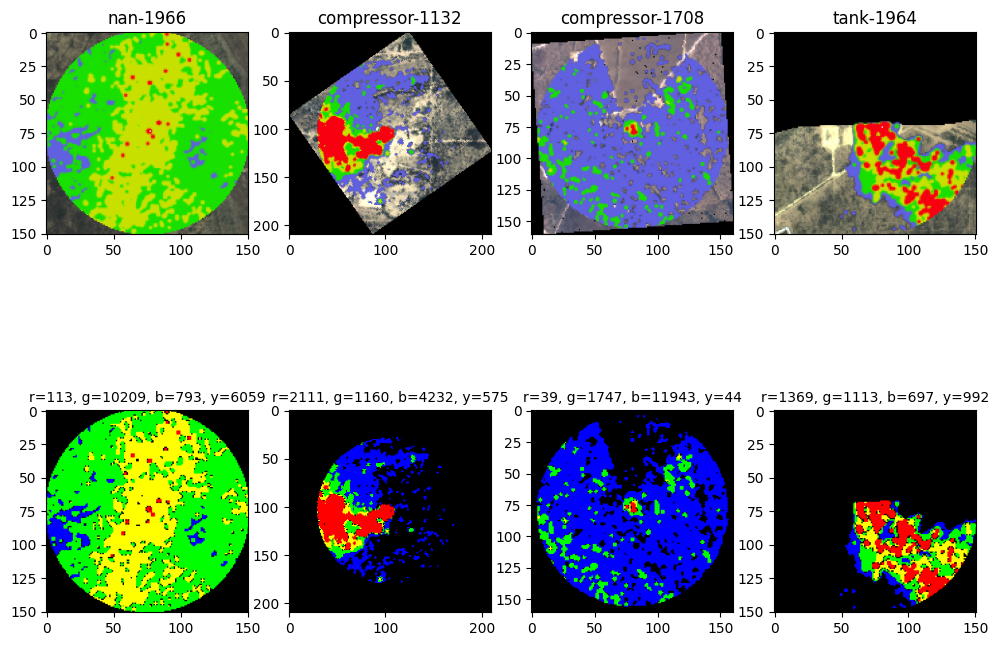

In [66]:

# Do some plotting
fig = plt.figure(figsize=(12,9))
fig.tight_layout(h_pad=4)
ax=plt.subplot(241)
ax.set_title("nan-1966")
image=imread("images/nan-1966.png")
plt.imshow(image)


ax=plt.subplot(245)

extracted_image,r,g,b,y=flare_extractor(image)
ax.set_title("r={}, g={}, b={}, y={}".format(r,g,b,y),fontsize=10)
plt.imshow(extracted_image)

ax=plt.subplot(242)
ax.set_title("compressor-1132")
image=imread("images/compressor-1132.png")
plt.imshow(image)


ax=plt.subplot(246)

extracted_image,r,g,b,y=flare_extractor(image)
ax.set_title("r={}, g={}, b={}, y={}".format(r,g,b,y),fontsize=10)
plt.imshow(extracted_image)


ax=plt.subplot(243)
ax.set_title("compressor-1708")
image=imread("images/compressor-1708.png")
plt.imshow(image)


ax=plt.subplot(247)

extracted_image,r,g,b,y=flare_extractor(image)
ax.set_title("r={}, g={}, b={}, y={}".format(r,g,b,y),fontsize=10)
plt.imshow(extracted_image)


ax=plt.subplot(244)
ax.set_title("tank-1964")
image=imread("images/tank-1964.png")
plt.imshow(image)


ax=plt.subplot(248)


extracted_image,r,g,b,y=flare_extractor(image)
ax.set_title("r={}, g={}, b={}, y={}".format(r,g,b,y),fontsize=10)
plt.imshow(extracted_image)


In [41]:
model=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1)
model.fit(X,y)
# output=model.score(X_test,y_test)
# output
y_pred=model.predict(X)
output_train=np.sqrt(mean_squared_error(y,y_pred))
output_train


219.39737467715835

In [42]:
import pickle
filename = 'finalized_LINEAR_model.sav'
pickle.dump(model, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))